<a href="https://colab.research.google.com/github/rpdahxn/CV_PaperReview/blob/main/03InfoGAN/InfoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random

mnist_model.py

In [2]:
import torch.nn.functional as F

"""
Architecture based on InfoGAN paper.
"""

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(74, 1024, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)

        self.tconv2 = nn.ConvTranspose2d(1024, 128, 7, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.tconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))

        img = torch.sigmoid(self.tconv4(x))

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
        self.bn3 = nn.BatchNorm2d(1024)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)

        return x

class DHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1024, 1, 1)

    def forward(self, x):
        output = torch.sigmoid(self.conv(x))

        return output

class QHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        self.conv_disc = nn.Conv2d(128, 10, 1)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

        disc_logits = self.conv_disc(x).squeeze()

        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())

        return disc_logits, mu, var

dataloader.py

In [3]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Directory containing the data.
root = 'data/'

def get_data(dataset, batch_size):

    # Get MNIST dataset.
    if dataset == 'MNIST':
        transform = transforms.Compose([
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.ToTensor()])

        dataset = dsets.MNIST(root+'mnist/', train='train', 
                                download=True, transform=transform)

    # Get SVHN dataset.
    elif dataset == 'SVHN':
        transform = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor()])

        dataset = dsets.SVHN(root+'svhn/', split='train', 
                                download=True, transform=transform)

    # Get FashionMNIST dataset.
    elif dataset == 'FashionMNIST':
        transform = transforms.Compose([
            transforms.Resize(28),
            transforms.CenterCrop(28),
            transforms.ToTensor()])

        dataset = dsets.FashionMNIST(root+'fashionmnist/', train='train', 
                                download=True, transform=transform)

    # Get CelebA dataset.
    # MUST ALREADY BE DOWNLOADED IN THE APPROPRIATE DIRECTOR DEFINED BY ROOT PATH!
    elif dataset == 'CelebA':
        transform = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                (0.5, 0.5, 0.5))])

        dataset = dsets.ImageFolder(root=root+'celeba/', transform=transform)

    # Create dataloader.
    dataloader = torch.utils.data.DataLoader(dataset, 
                                            batch_size=batch_size, 
                                            shuffle=True)

    return dataloader

utils.py

In [4]:
def weights_init(m):
    """
    Initialise weights of the model.
    """
    if(type(m) == nn.ConvTranspose2d or type(m) == nn.Conv2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif(type(m) == nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class NormalNLLLoss:
    """
    Calculate the negative log likelihood
    of normal distribution.
    This needs to be minimised.

    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):
        
        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll

def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.

    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx

config.py

In [5]:
# Dictionary storing network parameters.
params = {
    'batch_size': 128,# Batch size.
    'num_epochs': 100,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 25,# After how many epochs to save checkpoints and generate test output.
    'dataset' : 'MNIST'}# Dataset to use. Choose from {MNIST, SVHN, CelebA, FashionMNIST}. CASE MUST MATCH EXACTLY!!!!!

In [6]:
# Set random seed for reproducibility.
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  1123


In [7]:
# Use GPU if available.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

cuda:0  will be used.



In [8]:
dataloader = get_data(params['dataset'], params['batch_size'])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [9]:
# Set appropriate hyperparameters depending on the dataset used.
# The values given in the InfoGAN paper are used.
# num_z : dimension of incompressible noise.
# num_dis_c : number of discrete latent code used.
# dis_c_dim : dimension of discrete latent code.
# num_con_c : number of continuous latent code used.
params['num_z'] = 62
params['num_dis_c'] = 1
params['dis_c_dim'] = 10
params['num_con_c'] = 2

In [10]:
# Plot the training images.
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 100], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
# plt.savefig('Training Images {}'.format(params['dataset']))
plt.close('all')

In [11]:
# Initialise the network.
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (tconv1): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [12]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 1024, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [13]:
netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

DHead(
  (conv): Conv2d(1024, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [14]:
netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)

QHead(
  (conv1): Conv2d(1024, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_disc): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv_mu): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
  (conv_var): Conv2d(128, 2, kernel_size=(1, 1), stride=(1, 1))
)


In [15]:
# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()

In [16]:
# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=params['learning_rate'], betas=(params['beta1'], params['beta2']))

In [17]:
# Fixed Noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

In [18]:
real_label = 1
fake_label = 0

In [19]:
# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []

In [20]:
print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format(params['dataset']) % (params['num_epochs'], params['batch_size'], len(dataloader)))
print("-"*25)

-------------------------
Starting Training Loop...

Epochs: 100
Dataset: MNIST
Batch Size: 128
Length of Data Loader: 469
-------------------------


In [21]:
start_time = time.time()
iters = 0

In [22]:
for epoch in range(params['num_epochs']):
    epoch_start_time = time.time()

    for i, (data, _) in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device, dtype=torch.float)
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(params['num_dis_c']):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

        # Calculating loss for continuous latent code.
        con_loss = 0
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dis_c']*params['dis_c_dim'] : ].view(-1, params['num_con_c']), q_mu, q_var)*0.1

        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['num_epochs'], i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == params['num_epochs']/2):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        # plt.savefig("Epoch_%d {}".format(params['dataset']) %(epoch+1))
        plt.close('all')

    # Save network weights.
    # if (epoch+1) % params['save_epoch'] == 0:
    #     torch.save({
    #         'netG' : netG.state_dict(),
    #         'discriminator' : discriminator.state_dict(),
    #         'netD' : netD.state_dict(),
    #         'netQ' : netQ.state_dict(),
    #         'optimD' : optimD.state_dict(),
    #         'optimG' : optimG.state_dict(),
    #         'params' : params
    #         }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))
        


training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)


[1/100][100/469]	Loss_D: 0.8118	Loss_G: 1.8407
[1/100][200/469]	Loss_D: 0.5509	Loss_G: 2.0378
[1/100][300/469]	Loss_D: 0.5830	Loss_G: 2.2665
[1/100][400/469]	Loss_D: 0.2825	Loss_G: 2.3824
Time taken for Epoch 1: 64.30s
[2/100][100/469]	Loss_D: 0.2873	Loss_G: 2.5194
[2/100][200/469]	Loss_D: 0.5516	Loss_G: 2.6233
[2/100][300/469]	Loss_D: 0.5944	Loss_G: 2.1515
[2/100][400/469]	Loss_D: 0.7517	Loss_G: 2.1460
Time taken for Epoch 2: 65.42s
[3/100][100/469]	Loss_D: 0.6972	Loss_G: 1.6277
[3/100][200/469]	Loss_D: 0.8306	Loss_G: 1.5044
[3/100][300/469]	Loss_D: 0.7742	Loss_G: 1.5730
[3/100][400/469]	Loss_D: 0.8644	Loss_G: 1.4507
Time taken for Epoch 3: 65.03s
[4/100][100/469]	Loss_D: 0.8657	Loss_G: 1.4307
[4/100][200/469]	Loss_D: 0.7990	Loss_G: 1.4610
[4/100][300/469]	Loss_D: 0.9866	Loss_G: 1.1880
[4/100][400/469]	Loss_D: 0.9630	Loss_G: 1.1798
Time taken for Epoch 4: 64.54s
[5/100][100/469]	Loss_D: 0.8044	Loss_G: 1.5374
[5/100][200/469]	Loss_D: 0.9468	Loss_G: 1.2756
[5/100][300/469]	Loss_D: 0.884

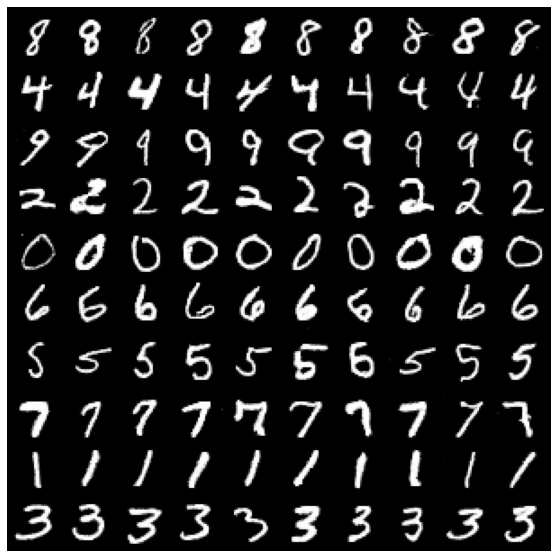

In [23]:
# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))

In [24]:
# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/model_final_{}'.format(params['dataset']))

FileNotFoundError: ignored

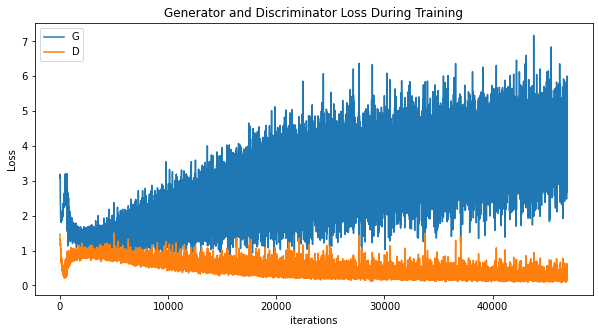

In [25]:
# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

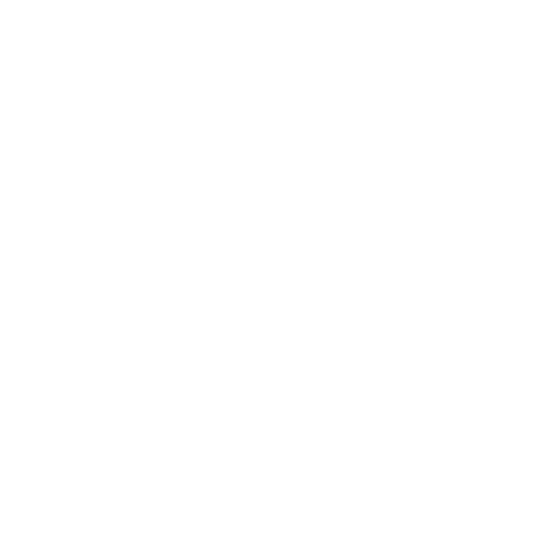

In [26]:
# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
plt.show()